In [1]:
## todo
# README.md
# optimizer : learning rate scheduler
# layer : rnn, batch normalization
# analysis : validation error
# fit : callbacks

# tf -> custom calcuration program

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import k.Activations.functions as Activations
import k.Layers.functions as Layers
import k.Losses.functions as Losses
import k.Optimizers.functions as Optimizers
import k.Initializers.functions as Initializer

2024-04-08 09:48:08.953117: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
class Neural_network:
    def __init__(self):
        self.network = []

    def to_object(self, param, class_):
        if type(param) == str:
            return class_(param)
        return param

    def compile(self, loss, optimizer, **kwargs):
        self.loss = self.to_object(loss, Losses.function)
        self.optimizer = self.to_object(optimizer, Optimizers.function)
        self.metrics = self.to_object(kwargs.get("metrics"), Losses.function)

        for layer in self.network:
            if not hasattr(layer, 'set_shape'):
                continue

            if layer.input_shape is None:
                layer.input_shape = output_shape

            layer.set_shape()
            output_shape = layer.output_shape

            if hasattr(layer, 'set_vars'):
                layer.set_vars(self.optimizer)

        self.network_depth = len(self.network)

    def predict(self, data):
        self.calcuration_graph = [data]

        for layer in self.network:
            data = layer.forward(data)
            self.calcuration_graph.append(data)

        return data

    def evaluate(self, x, y, **kwargs):
        graph_dict = {'loss' : [], 'metrics' : []}

        pred = self.predict(x)
        loss = self.loss.forward(y, pred)
        graph_dict['loss'] = loss

        metrics = kwargs.get("metrics")
        if metrics is not None:
            graph_dict['metrics'] = self.to_object(metrics, Losses.function).forward(y, pred)

        return graph_dict

    def print_expression(self, value):
        return f'{value:.4f}' if value > 0.0001 else f'{value:.4e}'

    def fit(self, x, y, batch_size, epochs, verbose, **kwargs):
        verbose = kwargs.get("verbose", 1)
        validation_data = kwargs.get("validation_data")

        graph_dict = {'loss' : [], 'val_loss' : [], 'metrics' : []}
        print_list = ['' for i in range(5)]

        data_num = x.shape[0]

        if batch_size > data_num:
            batch_size = data_num

        mini_batch_num = data_num//batch_size
        epoch_digits = len(str(epochs))

        for epoch in range(1, epochs+1):
            print_list[0] = f'epoch: {epoch:0{epoch_digits}d}'

            for batch in range(mini_batch_num):
                index = np.random.randint(data_num, size=batch_size)
                batch_x = x[index, :]
                batch_y = y[index, :]

                batch_p = self.predict(batch_x)

                loss = self.loss.forward(batch_y, batch_p)
                gradients = self.loss.backward(batch_y, batch_p)
                for i in range(self.network_depth):
                    gradients = self.network[-i-1].backward(gradients, self.calcuration_graph[-i-2], self.calcuration_graph[-i-1])

                
                print_list[1] = ' | batch : ' + f'{batch}/{mini_batch_num}'
                print_list[2] = ' | loss : ' + self.print_expression(loss)

                if verbose == 2:
                    print(print_list[0], print_list[1], print_list[2])

            if validation_data is not None:
                validation_loss = self.loss.forward(validation_data[1], self.predict(validation_data[0]))
                graph_dict['val_loss'].append(validation_loss)
                print_list[3] = ' | val_loss : ' + self.print_expression(validation_loss)

            if self.metrics is not None:
                metrics_value = self.metrics.forward(batch_y, batch_p)
                graph_dict['metrics'].append(metrics_value)
                print_list[4] = ' | metrics : ' + self.print_expression(metrics_value)

            if verbose == 1:
                print(print_list[0], print_list[2], print_list[3], print_list[4])

            graph_dict['loss'].append(loss)

        return graph_dict

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [5]:
x_train = np.array(x_train).reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)[0:1000]
x_test = np.array(x_test).reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)[0:100]
y_train = np.array(y_train).reshape(y_train.shape[0], 1)[0:1000]
y_test = np.array(y_test).reshape(y_test.shape[0], 1)[0:100]

In [6]:
x_train = x_train / 255
x_test = x_test / 255

In [7]:
y_train = np.eye(np.unique(y_train, axis=0).shape[0])[y_train][:,0,:]
y_test = np.eye(np.unique(y_test, axis=0).shape[0])[y_test][:,0,:]

In [11]:
model = Neural_network()
model.network.append(Layers.Convolution2D(input_shape=x_train.shape[1::], filters=128, kernel_shape=(3, 3)))
model.network.append(Activations.ReLU())
model.network.append(Layers.Pooling2D(pool_type='max'))
model.network.append(Layers.Convolution2D(filters=64, kernel_shape=(2, 2)))
model.network.append(Activations.ReLU())
model.network.append(Layers.Pooling2D(pool_type='mean'))
model.network.append(Layers.Flatten())
model.network.append(Layers.Dense(output_shape=32))
model.network.append(Activations.ReLU())
model.network.append(Layers.Dense(output_shape=10))
model.network.append(Activations.Softmax())

optimizer = Optimizers.Adam(learning_rate=1e-4)
model.compile('cce', optimizer, metrics='mae')

In [12]:
model.evaluate(x_test, y_test)

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.5412897>, 'metrics': []}

In [13]:
hist = model.fit(x_train, y_train, batch_size=256, epochs=10, verbose=1, validation_data=(x_test, y_test))

epoch: 01  | loss : 0.2719  | val_loss : 0.2649  | metrics : 0.1590
epoch: 02  | loss : 0.1555  | val_loss : 0.1972  | metrics : 0.1283
epoch: 03  | loss : 0.1804  | val_loss : 0.1489  | metrics : 0.1344
epoch: 04  | loss : 0.1375  | val_loss : 0.1316  | metrics : 0.1258
epoch: 05  | loss : 0.1244  | val_loss : 0.1177  | metrics : 0.1168
epoch: 06  | loss : 0.1097  | val_loss : 0.0927  | metrics : 0.1025
epoch: 07  | loss : 0.1084  | val_loss : 0.0768  | metrics : 0.0923
epoch: 08  | loss : 0.0930  | val_loss : 0.0657  | metrics : 0.0770
epoch: 09  | loss : 0.0876  | val_loss : 0.0614  | metrics : 0.0754
epoch: 10  | loss : 0.0677  | val_loss : 0.0582  | metrics : 0.0679


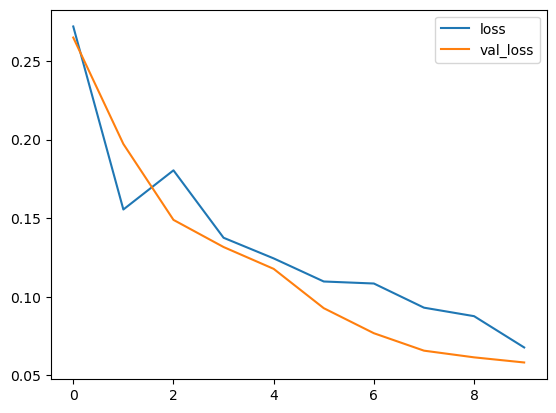

In [14]:
plt.plot(hist['loss'], label='loss')
plt.plot(hist['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [15]:
model.evaluate(x_test, y_test)

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.05817149>, 'metrics': []}

### make tensorflow model to compare

In [16]:
tf_model = tf.keras.Sequential()
tf_model.add(tf.keras.layers.Conv2D(128, input_shape=x_train.shape[1::], kernel_size=3, activation='relu'))
tf_model.add(tf.keras.layers.MaxPooling2D())
tf_model.add(tf.keras.layers.Conv2D(64, kernel_size=2, activation='relu'))
tf_model.add(tf.keras.layers.AveragePooling2D())
tf_model.add(tf.keras.layers.Flatten())
tf_model.add(tf.keras.layers.Dense(32, activation='relu'))
tf_model.add(tf.keras.layers.Dense(10, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
tf_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['mae'])

In [17]:
tf_model.evaluate(x_test, y_test)

4/4 [==============================] - 1s 20ms/step - loss: 2.2960 - mae: 0.1799


[2.295958995819092, 0.17985369265079498]

In [18]:
tf_hist = tf_model.fit(x_train, y_train, epochs=10, batch_size=256, verbose=1, validation_data=(x_test, y_test))

Epoch 1/10
4/4 [==============================] - 2s 279ms/step - loss: 2.2979 - mae: 0.1799 - val_loss: 2.2893 - val_mae: 0.1797
Epoch 2/10
4/4 [==============================] - 1s 260ms/step - loss: 2.2909 - mae: 0.1798 - val_loss: 2.2826 - val_mae: 0.1796
Epoch 3/10
4/4 [==============================] - 1s 242ms/step - loss: 2.2839 - mae: 0.1796 - val_loss: 2.2742 - val_mae: 0.1794
Epoch 4/10
4/4 [==============================] - 1s 260ms/step - loss: 2.2759 - mae: 0.1794 - val_loss: 2.2644 - val_mae: 0.1792
Epoch 5/10
4/4 [==============================] - 1s 249ms/step - loss: 2.2667 - mae: 0.1792 - val_loss: 2.2529 - val_mae: 0.1790
Epoch 6/10
4/4 [==============================] - 1s 263ms/step - loss: 2.2559 - mae: 0.1790 - val_loss: 2.2402 - val_mae: 0.1787
Epoch 7/10
4/4 [==============================] - 1s 322ms/step - loss: 2.2429 - mae: 0.1787 - val_loss: 2.2246 - val_mae: 0.1783
Epoch 8/10
4/4 [==============================] - 1s 233ms/step - loss: 2.2274 - mae: 0.17

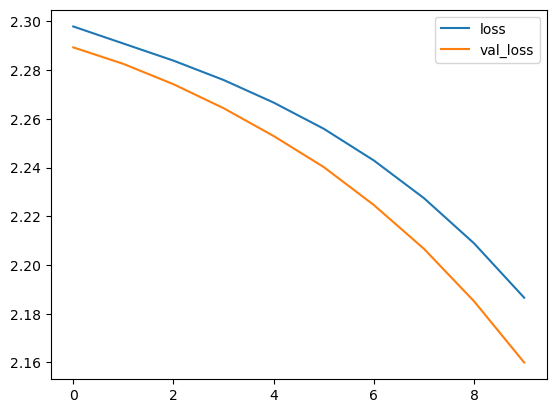

In [19]:
plt.plot(tf_hist.history['loss'], label='loss')
plt.plot(tf_hist.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [20]:
tf_model.evaluate(x_test, y_test)

4/4 [==============================] - 0s 8ms/step - loss: 2.1600 - mae: 0.1767


[2.159982204437256, 0.17674823105335236]